In [3]:
import sys

from llama_index.core.base.base_query_engine import BaseQueryEngine
sys.path.append('../')
from megaparse.cdp.utils.query_engine import get_query_engine
from pathlib import Path
import numpy as np

query_engine: BaseQueryEngine = get_query_engine(Path("../megaparse/cdp/CDP_QUAL_CHART_01_CHARTE_PRODUITS.md"))

In [4]:
from megaparse.cdp.utils.question_generator import QuestionGenerator

qg = QuestionGenerator()
questions = qg.generate_questions(Path("../megaparse/cdp/exemple_fournisseur_quiche.xlsx"), 'Fiche recette', language_verification= True)


Generating Questions ...
Verifying language and translating questions ...


In [5]:
questions_list = str(questions).split("\n")

In [6]:
test  = questions_list[14]
questions_list

['Voici la liste des questions traduites en français :',
 '',
 '1. Est-ce que "Farine (Flour)" est conforme aux exigences ?',
 '2. Est-ce que "Huiles et graisses végétales non hydrogénées de palme et de colza (Non-hydrogenated palm and rapeseed vegetable oils and fats)" est conforme aux exigences ?',
 '3. Est-ce que "Eau (Water)" est conforme aux exigences ?',
 '4. Est-ce que "Sel (Salt)" est conforme aux exigences ?',
 '5. Est-ce que "Emulsifiant (E471) (Emulsifier E471)" est conforme aux exigences ?',
 '6. Est-ce que "Acidifiant (E330) (Acidifier E330)" est conforme aux exigences ?',
 '7. Est-ce que "Poudre de LAIT entier (Whole milk powder)" est conforme aux exigences ?',
 '8. Est-ce que "Emulsifiant (E322 (SOJA)) (Emulsifier E322 (SOY))" est conforme aux exigences ?',
 '9. Est-ce que "Stabilisant (E339) (Stabilizer E339)" est conforme aux exigences ?',
 '10. Est-ce que "Stabilisant (E332) (Stabilizer E332)" est conforme aux exigences ?',
 '11. Est-ce que "Œufs (Eggs)" est conforme 

In [7]:
from typing import List
import pandas as pd
def compare(questions: List[str], category: str, verbose: bool = False):
    analysis = []
    
    for question in tqdm(questions):
        for i in range(3):
            try:
                response = query_engine.query(f"{question[:-1]} pour les produits de la catégorie {category} ?").response
            
            except Exception as e:
                if verbose:
                    print(f"Error with question: {question}")
                    print("Retry ...")
                    continue
            break
            

        analysis.append({
            'decision': response.decision,
            'name': response.name,
            'detailed_answer': response.detailed_answer
        })
     
    return pd.DataFrame(analysis)   

In [8]:
from enum import Enum

class DecisionEnum(str, Enum):
    authorized = 'Authorized'
    to_avoid = 'To Avoid'
    forbidden = 'Forbidden'

In [9]:
from tqdm import tqdm
generated_df = pd.DataFrame()
for i in range(1):
    print(f"Running iteration {i}")
    for category in ['Entree de Gamme','Coeur de Gamme', 'Haut de Gamme']:
        analysis = compare(questions_list, category = category, verbose=True)
        if "name" not in generated_df.columns:
            generated_df["name"] = analysis["name"]
        generated_df[f"{category}.{i}"] = analysis["decision"]

Running iteration 0


  0%|          | 0/32 [00:00<?, ?it/s]

Error with question: Voici la liste des questions traduites en français :
Retry ...


  0%|          | 0/32 [00:00<?, ?it/s]

Error with question: Voici la liste des questions traduites en français :
Retry ...


 97%|█████████▋| 31/32 [01:32<00:02,  2.87s/it]

Error with question: 30. Est-ce que "Muscade (Nutmeg)" est conforme aux exigences ?
Retry ...
Error with question: 30. Est-ce que "Muscade (Nutmeg)" est conforme aux exigences ?
Retry ...


100%|██████████| 32/32 [01:35<00:00,  2.97s/it]


Error with question: 30. Est-ce que "Muscade (Nutmeg)" est conforme aux exigences ?
Retry ...


100%|██████████| 32/32 [01:42<00:00,  3.20s/it]


In [18]:
df_category = generated_df[["name", "Haut de Gamme.0"]]
df_category

,name,Haut de Gamme.0
0,Ingrédients soumis à déclaration OGM,DecisionEnum.forbidden
1,Ingrédients soumis à déclaration OGM,DecisionEnum.forbidden
2,Farine (Flour),DecisionEnum.authorized
3,Non-hydrogenated palm and rapeseed vegetable o...,DecisionEnum.to_avoid
4,Eau (Water),DecisionEnum.authorized
5,Sel (Salt),DecisionEnum.authorized
6,Emulsifiant (E471),DecisionEnum.forbidden
7,Acidifiant (E330),DecisionEnum.authorized
8,Poudre de LAIT entier (Whole milk powder),DecisionEnum.authorized
9,Emulsifier E322 (SOY),DecisionEnum.authorized


In [199]:
#generated_df.to_csv("../megaparse/cdp/generated_1.csv", index = False)

In [20]:
def print_analysis(df: pd.DataFrame, category: str):
    print(f"En tant que produit de la catégorie : {category}")
    print("------------------------------------------------\n")

    print("\nProduit Autorisé : ")
    print("---------------------")
    df_category = df[["name", category]]
    authorized_products = df_category[df_category[category] == DecisionEnum.authorized]
    for _, row in authorized_products.iterrows():
        print(f"{row['name']}")
        #print(f"{row['name']} : {row['detailed_answer']}")

    print("\nProduit Toléré : ")
    print("---------------------")
    tolerated_products = df_category[df_category[category] == DecisionEnum.to_avoid]
    for _, row in tolerated_products.iterrows():
        print(f"{row['name']}")
        #print(f"{row['name']} : {row['detailed_answer']}")

    print("\nProduit Interdit : ")
    print("---------------------")
    forbidden_products = df_category[df_category[category] == DecisionEnum.forbidden]
    for _, row in forbidden_products.iterrows():
        print(f"{row['name']}")
        #print(f"{row['name']} : {row['detailed_answer']}")

In [23]:
print_analysis(generated_df, "Haut de Gamme.0")

En tant que produit de la catégorie : Haut de Gamme.0
------------------------------------------------


Produit Autorisé : 
---------------------
Farine (Flour)
Eau (Water)
Sel (Salt)
Acidifiant (E330)
Poudre de LAIT entier (Whole milk powder)
Emulsifier E322 (SOY)
Stabilisant (E332)
Œufs (Eggs)
CREME légère 98.5% (LAIT) (Light cream 98.5% (MILK))
Stabilisant (E440)
Stabilisant (E407)
Oignon (Onion)
Poivron rouge (Red pepper)
Tomates concassées (Crushed tomatoes)
Poivron vert (Green pepper)
Huile d'olive extra vierge (Extra virgin olive oil)
Sucre (Sugar)
Conservateur (E202) (Preservative E202)
Fécule de pomme de terre (Potato starch)
Ferments lactiques (Lactic ferments)
Coagulant microbien (Microbial coagulant)
Chlorure de calcium (Calcium chloride)
Herbes de Provence (Provence herbs)
Poivre noir (Black pepper)
Muscade (Nutmeg)

Produit Toléré : 
---------------------
Non-hydrogenated palm and rapeseed vegetable oils and fats
Amidon modifié (Modified starch)
Emulsifiant (E472e)

Prod

### Fill a table (simple)

In [24]:
cleaned_generated_df = generated_df.dropna()
def transform(x):
    return x.value if hasattr(x, 'value') else x

cleaned_generated_df.loc[:, cleaned_generated_df.columns != 'name'] = cleaned_generated_df.loc[:, cleaned_generated_df.columns != 'name'].applymap(transform)
cleaned_generated_df

/var/folders/s9/9lxl9nrd61j6qk6cjk30t4tm0000gn/T/ipykernel_61626/522448154.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  cleaned_generated_df.loc[:, cleaned_generated_df.columns != 'name'] = cleaned_generated_df.loc[:, cleaned_generated_df.columns != 'name'].applymap(transform)


,name,Entree de Gamme.0,Coeur de Gamme.0,Haut de Gamme.0
0,Ingrédients soumis à déclaration OGM,Forbidden,Forbidden,Forbidden
1,Ingrédients soumis à déclaration OGM,Forbidden,Authorized,Forbidden
2,Farine (Flour),Authorized,Authorized,Authorized
3,Non-hydrogenated palm and rapeseed vegetable o...,To Avoid,To Avoid,To Avoid
4,Eau (Water),Authorized,Authorized,Authorized
5,Sel (Salt),Authorized,Authorized,Authorized
6,Emulsifiant (E471),To Avoid,To Avoid,Forbidden
7,Acidifiant (E330),Authorized,Authorized,Authorized
8,Poudre de LAIT entier (Whole milk powder),Authorized,Authorized,Authorized
9,Emulsifier E322 (SOY),Authorized,Authorized,Authorized


In [64]:
from pandas import DataFrame


ground_truth_df: DataFrame = pd.read_csv('../megaparse/cdp/ground_truth_quiche.csv')
ground_truth_df

,name,Entree de Gamme,Coeur de Gamme,Haut de Gamme
0,Farine,Authorized,Authorized,Authorized
1,huiles et graisses végétales non hydrogénées d...,Forbidden,Forbidden,Forbidden
2,Eau,Authorized,Authorized,Authorized
3,sel,Authorized,Authorized,Authorized
4,E471,To Avoid,To Avoid,To Avoid
5,E330,Authorized,Authorized,Authorized
6,poudre de lait entier,Authorized,Authorized,Authorized
7,E322,Authorized,Authorized,Authorized
8,E339,To Avoid,Forbidden,Forbidden
9,E332,Authorized,Authorized,Authorized


In [65]:
import re

def clean_name(name):
    name = name.lower()
    
    name = re.sub(r'[^a-z0-9\s]', '', name)
    
    name = re.sub(r'\s+', ' ', name)
    
    return name.strip()  

cleaned_generated_df['cleaned_name'] = cleaned_generated_df['name'].apply(clean_name)
ground_truth_df['cleaned_name'] = ground_truth_df['name'].apply(clean_name)

In [66]:
import difflib

# Function to perform fuzzy matching using difflib
def fuzzy_match(name, choices, threshold=0.8):
    matches = [g_name for g_name in choices if name in g_name]
    if matches:
        return matches
    

    matches = difflib.get_close_matches(name, choices, n=1, cutoff=threshold)
    if matches:
        return matches
    else:
        return None
    

# Apply fuzzy matching to each name in df1 and find the closest match in df2
for name1 in ground_truth_df['cleaned_name']:
    matched_names = fuzzy_match(name1, cleaned_generated_df['cleaned_name'])
    if matched_names:
        print(f"The best match found: {name1} -> {matched_names[0]}")
    else:
        print(f"No match found for: {name1}")

The best match found: farine -> farine flour
No match found for: huiles et graisses vgtales non hydrognes de palme et de colza
The best match found: eau -> eau water
The best match found: sel -> sel salt
The best match found: e471 -> emulsifiant e471
The best match found: e330 -> acidifiant e330
The best match found: poudre de lait entier -> poudre de lait entier whole milk powder
The best match found: e322 -> emulsifier e322 soy
The best match found: e339 -> stabilizer e339
The best match found: e332 -> stabilisant e332
No match found for: creme legere 985 lait
The best match found: amidon modifi -> amidon modifi modified starch
The best match found: e472e -> emulsifiant e472e
The best match found: e440 -> stabilisant e440
The best match found: e407 -> stabilisant e407
The best match found: oignon -> oignon onion
The best match found: poivron rouge -> poivron rouge red pepper
The best match found: tomates concasses -> tomates concasses crushed tomatoes
The best match found: poivron ve

In [67]:
cleaned_generated_df

,name,Entree de Gamme.0,Coeur de Gamme.0,Haut de Gamme.0,cleaned_name
0,Ingrédients soumis à déclaration OGM,Forbidden,Forbidden,Forbidden,ingrdients soumis dclaration ogm
1,Ingrédients soumis à déclaration OGM,Forbidden,Authorized,Forbidden,ingrdients soumis dclaration ogm
2,Farine (Flour),Authorized,Authorized,Authorized,farine flour
3,Non-hydrogenated palm and rapeseed vegetable o...,To Avoid,To Avoid,To Avoid,nonhydrogenated palm and rapeseed vegetable oi...
4,Eau (Water),Authorized,Authorized,Authorized,eau water
5,Sel (Salt),Authorized,Authorized,Authorized,sel salt
6,Emulsifiant (E471),To Avoid,To Avoid,Forbidden,emulsifiant e471
7,Acidifiant (E330),Authorized,Authorized,Authorized,acidifiant e330
8,Poudre de LAIT entier (Whole milk powder),Authorized,Authorized,Authorized,poudre de lait entier whole milk powder
9,Emulsifier E322 (SOY),Authorized,Authorized,Authorized,emulsifier e322 soy


In [68]:
matched_rows = []
ground_truth_df_copy = ground_truth_df.copy()

for name1 in ground_truth_df['cleaned_name']:
    matched_name = fuzzy_match(name1, cleaned_generated_df['cleaned_name'])
    if matched_name:
        matched_row = cleaned_generated_df.loc[cleaned_generated_df['cleaned_name'] == matched_name[0]].copy()
        matched_row['cleaned_name'] = name1
        matched_rows.append(matched_row)
    else:
        print("no match found for: ", name1)
        ground_truth_df_copy = ground_truth_df_copy[ground_truth_df_copy['cleaned_name'] != name1]
        
ground_truth_df_copy.reset_index(drop=True, inplace=True)
        


# Create the matched_generated_df DataFrame from the list of matched rows
if matched_rows:
    matched_generated_df = pd.concat(matched_rows, ignore_index=True)
else:
    matched_generated_df = pd.DataFrame(columns=cleaned_generated_df.columns)

# Display the matched_generated_df DataFrame
matched_generated_df

no match found for:  huiles et graisses vgtales non hydrognes de palme et de colza
no match found for:  creme legere 985 lait
no match found for:  amidon modifi de pomme de terre
no match found for:  e410
no match found for:  huile dolive vierge
no match found for:  emmental


,name,Entree de Gamme.0,Coeur de Gamme.0,Haut de Gamme.0,cleaned_name
0,Farine (Flour),Authorized,Authorized,Authorized,farine
1,Eau (Water),Authorized,Authorized,Authorized,eau
2,Sel (Salt),Authorized,Authorized,Authorized,sel
3,Emulsifiant (E471),To Avoid,To Avoid,Forbidden,e471
4,Acidifiant (E330),Authorized,Authorized,Authorized,e330
5,Poudre de LAIT entier (Whole milk powder),Authorized,Authorized,Authorized,poudre de lait entier
6,Emulsifier E322 (SOY),Authorized,Authorized,Authorized,e322
7,Stabilizer E339,To Avoid,Forbidden,Forbidden,e339
8,Stabilisant (E332),Authorized,Authorized,Authorized,e332
9,Amidon modifié (Modified starch),To Avoid,To Avoid,To Avoid,amidon modifi


In [69]:
ground_truth_df_copy

,name,Entree de Gamme,Coeur de Gamme,Haut de Gamme,cleaned_name
0,Farine,Authorized,Authorized,Authorized,farine
1,Eau,Authorized,Authorized,Authorized,eau
2,sel,Authorized,Authorized,Authorized,sel
3,E471,To Avoid,To Avoid,To Avoid,e471
4,E330,Authorized,Authorized,Authorized,e330
5,poudre de lait entier,Authorized,Authorized,Authorized,poudre de lait entier
6,E322,Authorized,Authorized,Authorized,e322
7,E339,To Avoid,Forbidden,Forbidden,e339
8,E332,Authorized,Authorized,Authorized,e332
9,amidon modifié,Authorized,Authorized,Authorized,amidon modifi


In [70]:
correct_predictions = {}
for column in matched_generated_df.columns:
    if column == 'name' or column == 'cleaned_name':
        continue
    correct_predictions[column] = (matched_generated_df[column] == ground_truth_df_copy[column[:-2]]).sum()

total_predictions = len(matched_generated_df)

accuracy = {category : correct_predictions[category] / total_predictions for category in correct_predictions.keys()}

In [75]:
print(f"Mean Accuracy on all categories: {np.mean(list(accuracy.values()))* 100:.2f}%")

for gamme in ["Entree de Gamme", "Coeur de Gamme", "Haut de Gamme"]:
    mean_gamme_acc = np.mean([value for key, value in accuracy.items() if gamme in key])
    print(f"Mean Accuracy on {gamme} columns: {mean_gamme_acc * 100:.2f}%")

Mean Accuracy on all categories: 91.67%
Mean Accuracy on Entree de Gamme columns: 92.86%
Mean Accuracy on Coeur de Gamme columns: 92.86%
Mean Accuracy on Haut de Gamme columns: 89.29%


In [76]:
errors_count = {"Entree de Gamme": {}, "Coeur de Gamme": {}, "Haut de Gamme": {}}

for category in matched_generated_df.columns:
    if category in ['cleaned_name', 'name']:
        continue
    ground_truth_category = category[:-2]
    errors = matched_generated_df[matched_generated_df[category] != ground_truth_df_copy[ground_truth_category]]
    
    for index, row in errors.iterrows():
        key = ground_truth_df_copy.at[index, 'cleaned_name']  # Using cleaned_name as the key
        if key in errors_count[ground_truth_category]:
            errors_count[ground_truth_category][key] += 1
        else:
            errors_count[ground_truth_category][key] = 1

errors_count

{'Entree de Gamme': {'amidon modifi': 1, 'e407': 1},
 'Coeur de Gamme': {'amidon modifi': 1, 'e407': 1},
 'Haut de Gamme': {'e471': 1, 'amidon modifi': 1, 'e407': 1}}

In [131]:
matched_generated_df.columns[1:-1]

Index(['Entree de Gamme.0', 'Coeur de Gamme.0', 'Haut de Gamme.0'], dtype='object')

In [141]:
test = matched_generated_df.drop(columns=["cleaned_name", "name"])
pd.unique(test.values.ravel('K'))

array(['Authorized', 'To Avoid', 'Forbidden'], dtype=object)

In [129]:
metrics

{'Entree de Gamme.0': {'confusion_matrix': array([[23,  1,  0],
         [ 1,  3,  0],
         [ 0,  0,  0]]),
  'accuracy': 0.9285714285714286,
  'precision': {'Authorized': 0.9583333333333334,
   'To Avoid': 0.75,
   'Forbidden': 0.0},
  'recall': {'Authorized': 0.9583333333333334,
   'To Avoid': 0.75,
   'Forbidden': 0.0}},
 'Coeur de Gamme.0': {'confusion_matrix': array([[23,  1,  0],
         [ 1,  2,  0],
         [ 0,  0,  1]]),
  'accuracy': 0.9285714285714286,
  'precision': {'Authorized': 0.9583333333333334,
   'To Avoid': 0.6666666666666666,
   'Forbidden': 1.0},
  'recall': {'Authorized': 0.9583333333333334,
   'To Avoid': 0.6666666666666666,
   'Forbidden': 1.0}},
 'Haut de Gamme.0': {'confusion_matrix': array([[23,  1,  0],
         [ 1,  1,  1],
         [ 0,  0,  1]]),
  'accuracy': 0.8928571428571429,
  'precision': {'Authorized': 0.9583333333333334,
   'To Avoid': 0.5,
   'Forbidden': 0.5},
  'recall': {'Authorized': 0.9583333333333334,
   'To Avoid': 0.3333333333333

In [116]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
def compute_metrics(predicted_df, ground_truth_df):
    categories = ['Entree de Gamme', 'Coeur de Gamme', 'Haut de Gamme']
    labels = ['Authorized', 'To Avoid', 'Forbidden']
    
    # Initialize dictionaries to hold the metrics for each category
    metrics = {}
    
    for category in predicted_df.columns[1:-1]:
        y_true = ground_truth_df[category[:-2]]
        y_pred = predicted_df[category]
        
        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        
        # Compute accuracy
        accuracy = accuracy_score(y_true, y_pred)
        
        # Compute precision and recall for each label
        precision = precision_score(y_true, y_pred, labels=labels, average=None)
        recall = recall_score(y_true, y_pred, labels=labels, average=None)
        
        # Store the metrics in the dictionary
        metrics[category] = {
            'confusion_matrix': cm,
            'accuracy': accuracy,
            'precision': dict(zip(labels, precision)),
            'recall': dict(zip(labels, recall))
        }
    
    # Compute overall metrics
    n_iterations = (len(predicted_df.columns) - 2) // (len(ground_truth_df.columns) - 2)
    y_true_all = ground_truth_df[categories].values.flatten()
    y_true_all = np.tile(y_true_all, n_iterations)
    y_pred_all = predicted_df[predicted_df.columns[1:-1]].values.flatten()
    
    overall_cm = confusion_matrix(y_true_all, y_pred_all, labels=labels)
    overall_accuracy = accuracy_score(y_true_all, y_pred_all)
    overall_precision = precision_score(y_true_all, y_pred_all, labels=labels, average=None)
    overall_recall = recall_score(y_true_all, y_pred_all, labels=labels, average=None)
    
    overall_metrics = {
        'confusion_matrix': overall_cm,
        'accuracy': overall_accuracy,
        'precision': dict(zip(labels, overall_precision)),
        'recall': dict(zip(labels, overall_recall))
    }
    
    return metrics, overall_metrics


In [ ]:
metrics, overall_metrics = compute_metrics(matched_generated_df, ground_truth_df_copy)

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def display_metrics(metrics, overall_metrics):
    
    for category in metrics.keys():
        print(f"\nMetrics for {category}:")
        print("="*50)
        
        # Display the confusion matrix
        cm = metrics[category]['confusion_matrix']
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Authorized', 'To Avoid', 'Forbidden'], yticklabels=['Authorized', 'To Avoid', 'Forbidden'])
        plt.title(f'Confusion Matrix for {category}')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()
        
        # Display accuracy
        print(f"Accuracy: {metrics[category]['accuracy']*100:.2f}%")
        
        # Display precision and recall
        precision_recall_df = pd.DataFrame({
            'Precision': metrics[category]['precision'],
            'Recall': metrics[category]['recall']
        })
        print(precision_recall_df)
    
    print("\nOverall Metrics:")
    print("="*50)
    
    # Display the overall confusion matrix
    overall_cm = overall_metrics['confusion_matrix']
    plt.figure(figsize=(8, 6))
    sns.heatmap(overall_cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Authorized', 'To Avoid', 'Forbidden'], yticklabels=['Authorized', 'To Avoid', 'Forbidden'])
    plt.title('Overall Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    
    # Display overall accuracy
    print(f"Overall Accuracy: {overall_metrics['accuracy']*100:.2f}%")
    
    # Display overall precision and recall
    overall_precision_recall_df = pd.DataFrame({
        'Precision': overall_metrics['precision'],
        'Recall': overall_metrics['recall']
    })
    print(overall_precision_recall_df)


Metrics for Entree de Gamme.0:


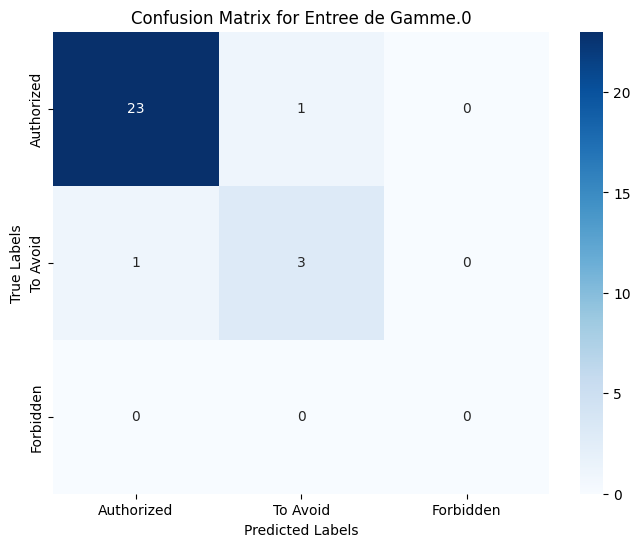

Accuracy: 92.86%
            Precision    Recall
Authorized   0.958333  0.958333
To Avoid     0.750000  0.750000
Forbidden    0.000000  0.000000

Metrics for Coeur de Gamme.0:


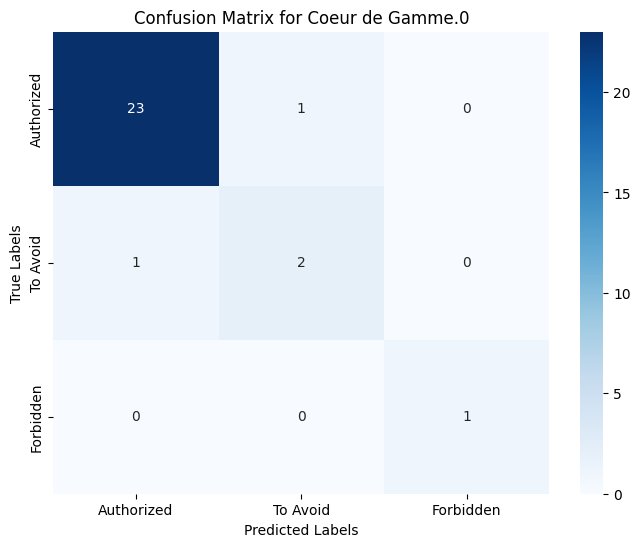

Accuracy: 92.86%
            Precision    Recall
Authorized   0.958333  0.958333
To Avoid     0.666667  0.666667
Forbidden    1.000000  1.000000

Metrics for Haut de Gamme.0:


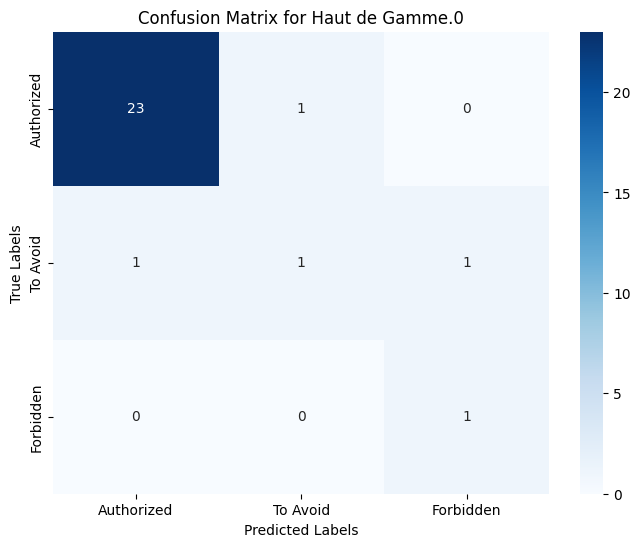

Accuracy: 89.29%
            Precision    Recall
Authorized   0.958333  0.958333
To Avoid     0.500000  0.333333
Forbidden    0.500000  1.000000

Overall Metrics:


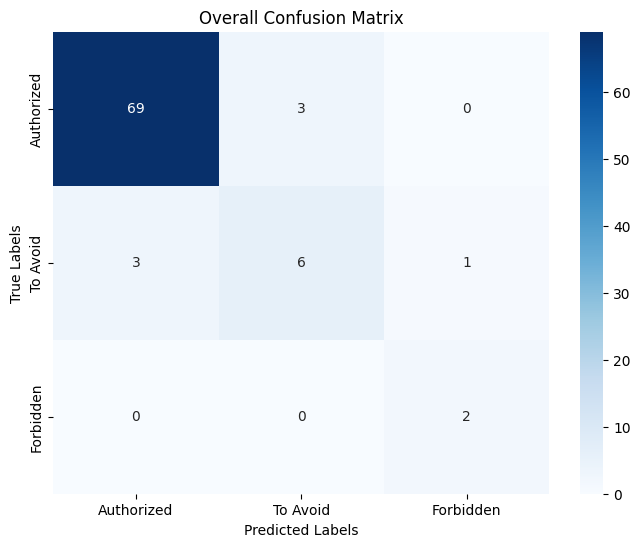

Overall Accuracy: 91.67%
            Precision    Recall
Authorized   0.958333  0.958333
To Avoid     0.666667  0.600000
Forbidden    0.666667  1.000000


In [128]:
display_metrics(metrics, overall_metrics)